Roary pangenome plots
=============

<h6><a href="javascript:toggle()" target="_self">Toggle source code</a></h6>

In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [2]:
# Other imports
import os
import pandas as pd
import numpy as np
from Bio import Phylo

parSNP tree
-------------

Any other valid newick file is fine, if the tip labels is the same as in the gene_presence_absence matrix from roary.

In [3]:
t = Phylo.read('parsnp.tree', 'newick')

In [4]:
# Max distance to create better plots
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

Roary
------

In [5]:
# Load roary
roary = pd.read_table('gene_presence_absence.csv',
                     sep=',',
                     low_memory=False)
# Set index (group name)
roary.set_index('Gene', inplace=True)
# Drop the other info columns
roary.drop(list(roary.columns[:13]), axis=1, inplace=True)

In [6]:
# Transform it in a presence/absence matrix (1/0)
roary.replace('.{2,100}', 1, regex=True, inplace=True)
roary.replace(np.nan, 0, regex=True, inplace=True)

In [7]:
# Sort the matrix by the sum of strains presence
idx = roary.sum(axis=1).sort_values(ascending=False).index
roary_sorted = roary.ix[idx]

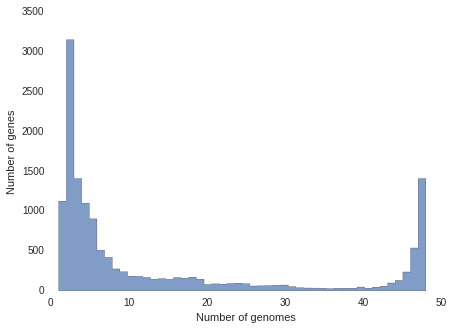

In [8]:
# Pangenome frequency plot
plt.figure(figsize=(7, 5))

plt.hist(roary.sum(axis=1), roary.shape[1],
         histtype="stepfilled", alpha=.7)

plt.xlabel('Number of genomes')
plt.ylabel('Number of genes')

sns.despine(left=True,
            bottom=True)

In [9]:
# Sort the matrix according to tip labels in the tree
roary_sorted = roary_sorted[[x.name for x in t.get_terminals()]]

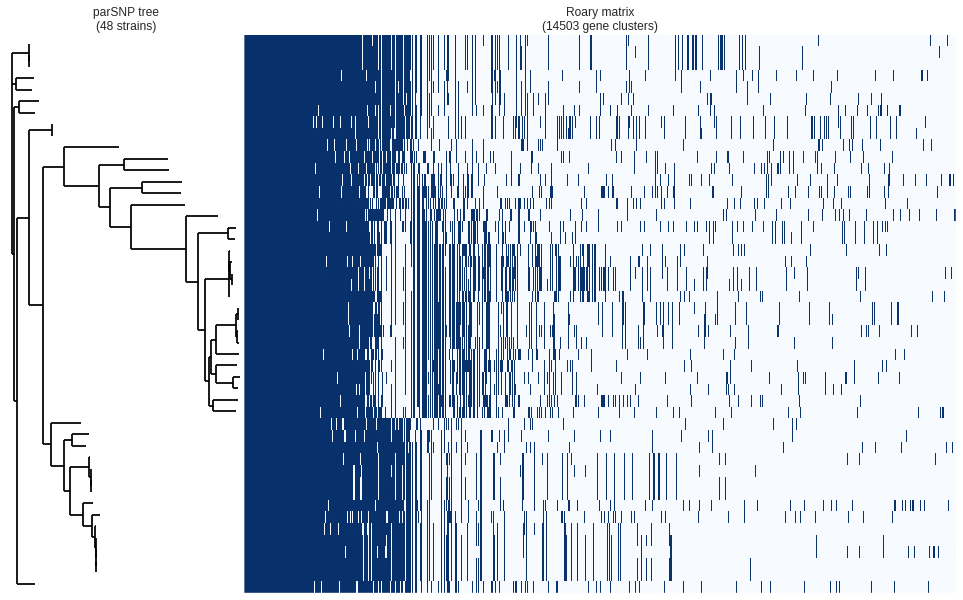

In [10]:
# PLot presence/absence matrix against the tree
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(roary_sorted.T, cmap=plt.cm.Blues,
               vmin=0, vmax=1,
               aspect='auto',
               interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('Roary matrix\n(%d gene clusters)'%roary.shape[0])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n(%d strains)'%roary.shape[1],), 
              )

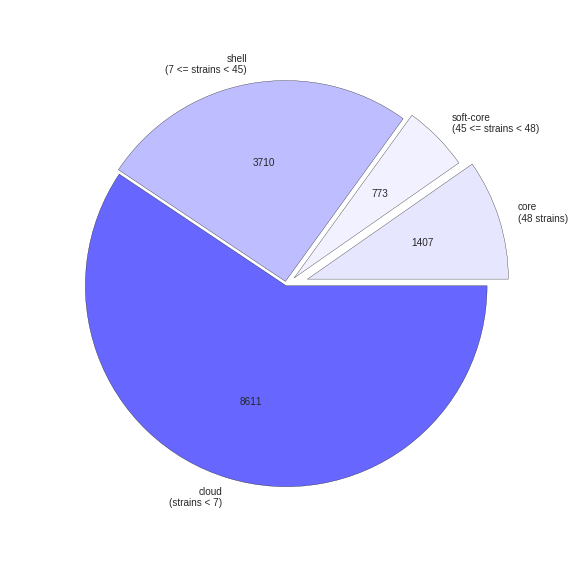

In [11]:
# Plot the pangenome pie chart
plt.figure(figsize=(10, 10))

core = roary[roary.sum(axis=1) == roary.shape[1]].shape[0]
softcore = roary[(roary.sum(axis=1) < roary.shape[1]) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.95)].shape[0]
shell = roary[(roary.sum(axis=1) < roary.shape[1]*0.95) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.15)].shape[0]
cloud = roary[roary.sum(axis=1) < roary.shape[1]*0.15].shape[0]

total = roary.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud],
      labels=['core\n(%d strains)'%roary.shape[1],
              'soft-core\n(%d <= strains < %d)'%(roary.shape[1]*.95,
                                                 roary.shape[1]),
              'shell\n(%d <= strains < %d)'%(roary.shape[1]*.15,
                                             roary.shape[1]*.95),
              'cloud\n(strains < %d)'%(roary.shape[1]*.15)],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)